<a href="https://colab.research.google.com/github/Spica08/Deep-Learning-from-Scratch/blob/main/4%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
#setup
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [76]:
#function

#恒等関数
def identity_function(x):
    return x

#ステップ関数
def step_function(x):
  y = x > 0
  return y.astype(int)

#シグモイド関数
def sigmoid(x):
  return 1/(1+np.exp(-x))

#ReLU関数
def ReLU(x):
  return np.maximum(0,x)

#ソフトマックス関数
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

#2乗和誤差
def mean_square_error(y, t):
  return 0.5 * np.sum((y-t)**2)

#交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 4章 ニューラルネットワークの学習

## 4.1 データから学習する
ニューラルネットワークの特徴は、データから学習できる点にある。

### 4.1.1 データ駆動
機械学習、特にニューラルネットワークでは、人の介入が少なく集められたデータから答えを見つけようとする。  
例えば、「5」という数字を画像から見分ける問題を考えてみる。これは人にとっては簡単だが、その判断基準を明確に述べることは困難である。そこで、「5」を認識するために、データを活用して解決してみる。1つの方法として、画像から特徴量を抽出してその特徴量のパターンを機械学習の技術で学習する方法が考えられる。画像データの特徴量は通常ベクトルとして表される。この特徴量を用いて画像データをベクトルに変換し、SVMやKNNなどで学習させることができる。  
上述した機械学習によるアプローチでは、機械が規則性を見つけ出す。一方で、画像をベクトルに変換する際に使用した特徴量の作成には人が関わっていることに注意する必要がある。実際、問題に応じて適した特徴量を用いなければ良い結果を得ることはできない。これに対して、ニューラルネットワークでは人は介入せず、画像をそのまま学習する。ここでは、画像に含まれる重要な特徴量までも機械が学習するのである。

### 4.1.2 訓練データとテストデータ
機械学習の問題では、訓練データとテストデータの2つを用いて学習、モデル作成を行う。

## 4.2 損失関数
ニューラルネットワークの学習では、ある指標によって現在の状態を表す。この指標を損失関数と呼ぶ。この損失関数には任意の関数を用いることができるが、一般には2乗和誤差や交差エントロピー誤差などが用いられる。

### 4.2.1 2乗和誤差
損失関数に用いられる関数として最も有名なものが2乗和誤差であり、以下の数式で表される。  
$E = \frac{1}{2}\sum_k(y_k-t_k)^2$  


In [53]:
#2乗和誤差の計算
def mean_square_error(y, t):
  return 0.5 * np.sum((y-t)**2)

In [54]:
#確認
t = [0,0,1,0,0,0,0,0,0,0] # 正解
y = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
print(mean_square_error(np.array(t),np.array(y)))
y = [0.1,0.05,0.1,0.0,0.05,0.1,0,0.6,0.0,0.0]
print(mean_square_error(np.array(t),np.array(y)))

0.09750000000000003
0.5975


より正解に近い出力結果における損失関数の値が小さくなることが確認できた。

### 4.2.2 交差エントロピー誤差
2乗和誤差と別の損失関数として交差エントロピー誤差も用いられ、以下の数式で表される。  
$E = -\sum_kt_k\log{y_k}$  
tはone-hot表現した時の正解ラベル(正解のみ1、その他は0)。

In [55]:
#交差エントロピーの計算
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta))

In [56]:
#確認
t = [0,0,1,0,0,0,0,0,0,0] # 正解
y = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
print(cross_entropy_error(np.array(y),np.array(t)))
y = [0.1,0.05,0.1,0.0,0.05,0.1,0,0.6,0.0,0.0]
print(cross_entropy_error(np.array(y),np.array(t)))

0.510825457099338
2.302584092994546


より正解に近い出力結果における損失関数の値が小さくなることが確認できた。

### 4.2.3 ミニバッチ学習  
学習において、損失関数は全ての訓練データを対象に求める。具体的には、全データの損失関数の平均を用いる。一方で、訓練データ数が膨大になると、この損失関数の計算が現実的な時間で行えなくなる。  
そこで、データの中から一部を選び出し、その一部のデータを全体の「近似」として利用する。これをミニバッチ学習と呼ぶ。

In [57]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# mnist.pyをインポート
import sys, os
sys.path.append("/content/drive/MyDrive/Colab Notebooks/ゼロから作るDeep Learning")
from mnist import load_mnist

In [59]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

#各データの形状を確認
print("x_train.shape {}".format(x_train.shape))
print("t_train.shape {}".format(t_train.shape))
print("x_test.shape {}".format(x_test.shape))
print("t_test.shape {}".format(t_test.shape))

x_train.shape (60000, 784)
t_train.shape (60000, 10)
x_test.shape (10000, 784)
t_test.shape (10000, 10)


In [60]:
#ミニバッチ学習用にランダムに10個のデータを抽出
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### 4.2.4 バッチ対応版交差エントロピー誤差の実装

In [61]:
def cross_entropy_error(y,t):
  #データが1次元の場合、2次元配列に整形する
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0] # データ数
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

### 4.2.5 なぜ損失関数を設定するのか?
なぜ認識精度ではなく損失関数を設定し指標とするのか。  
これは、ニューラルネットワークにおける「微分」の役割に注目すると解決できる。ニューラルネットワークにおけるパラメータの探索では、パラメータの微分を計算し、その微分の値を手がかりにパラメータを徐々に更新していく。  
認識精度を指標にしてはいけない理由は、微分がほとんどの場所で0になってしまい、パラメータの更新ができなくなってしまうからである。認識精度を指標にすると、パラメータを少し更新しただけでは精度が改善せず、パラメータの更新が行えなくなってしまう。仮に精度が向上したとしても、値は不連続になってしまう。  


## 4.3 数値微分
勾配法では、勾配の情報を使って進む方向を決める。

### 4.3.1 微分
微分とはある瞬間の変化の量を表したもので以下の式で表される。  
$\frac{df(x)}{dx} = lim_{x \to 0}\frac{f(x+h)-f(x)}{h}$  

プログラムで数値微分を実装する際は以下の2点に留意して実装する必要がある。  
(1) 微小な値hとして1e-4を用いる。(小さすぎると丸め誤差で0になってしまう)  
(2) (x + h)と(x - h)でのfの差分を計算する(ナイーブな実装だとhを無限に0に近づけることができないのが理由で誤差が発生してしまう)。


In [62]:
#数値微分
def numerical_diff(f, x):
  h = 1e-4
  return (f(x + h) - f(x - h)) / (2 * h)

### 4.3.2 数値微分の例
数値微分を使って以下の簡単な関数を実際に微分してみる。  
$y = 0.01x^2 + 0.1x$  


In [63]:
#関数の定義
def function_1(x):
  return 0.01 * x **2 + 0.1 * x

Text(0, 0.5, 'f(x)')

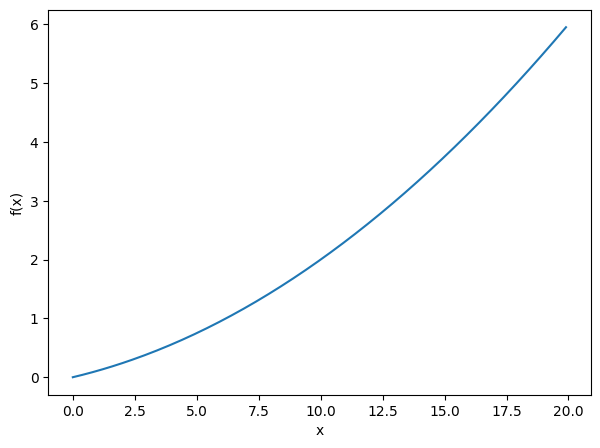

In [64]:
#グラフの描画
x = np.arange(0, 20, 0.1)
y = function_1(x)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")

In [65]:
# x = 5およびx = 10の時の微分
grad_5 = numerical_diff(function_1, 5)
grad_10 = numerical_diff(function_1, 10)
print("numerical diff at x = 5 : {}".format(grad_5))
print("numerical diff at x = 10 : {}".format(grad_10))

numerical diff at x = 5 : 0.1999999999990898
numerical diff at x = 10 : 0.2999999999986347


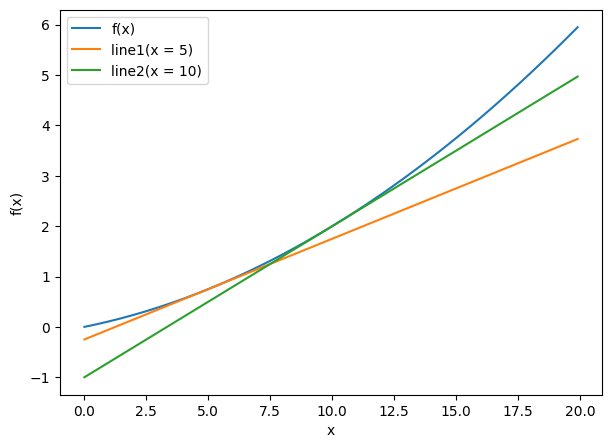

In [66]:
#接戦の描画
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x, y)
ax.plot(x, grad_5 * x - grad_5 * 5 + function_1(5))
ax.plot(x, grad_10 * x - grad_10 * 10 + function_1(10))
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.legend(["f(x)", "line1(x = 5)", "line2(x = 10)"])

### 4.3.3 偏微分
以下の2変数関数について考える。  
$f(x_0, x_1) = x_0^2 + x_1^2$

In [67]:
def function_2(x : np.array):
  return np.sum(x**2)

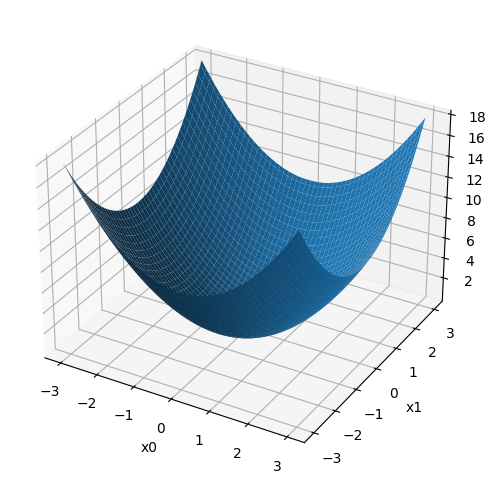

In [68]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
x0 = np.linspace(-3,3,100)
x1 = np.linspace(-3,3,100)
x0, x1 = np.meshgrid(x0, x1)
fx = x0**2+x1**2
ax.plot_surface(x0, x1, fx)
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("fx")
fig.show()

この式には変数が2つあるため、「どの変数に対しての微分か」を区別する必要がある。このような複数の変数からなる関数の微分を偏微分と呼ぶ。  


## 4.4 勾配
先ほどの例において、x0とx1の偏微分をまとめて計算することを考える。点(x0、x1)での偏微分をまとめて$(\partial f/\partial x_0, \partial f/\partial x_1)$とまとめたものを勾配と呼ぶ。

In [69]:
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    idx = it.multi_index
    tmp_val = x[idx]

    x[idx] = tmp_val + h
    fxh1 = f(x) # f(x+h)

    x[idx] = tmp_val - h
    fxh2 = f(x) # f(x-h)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val # 値を元に戻す
    it.iternext()
  return grad

In [23]:
print(numerical_gradient(function_2, np.array([3.0,4.0])))
print(numerical_gradient(function_2, np.array([0.0,2.0])))
print(numerical_gradient(function_2, np.array([3.0,0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


この勾配の方向は、各場所において関数の値を最も減らす方向である。

### 4.4.1 勾配法
ニューラルネットワークでは、損失関数が最小値を取るようなパラメータを探索するが、一般に損失関数は複雑でありどこに最小値を取る場所があるのかを探索するのは難しい。そこで、勾配を利用してそのような点を探索する手法(勾配法)を用いる。  
注意点として、勾配が指す方向は各地点における関数の値を最も減らす方向であり、それが関数自体の最小値であることはほとんどない。  

勾配法を数式で表すと以下のようになる。  
$x_0 = x_0 - η\frac{\partial f}{\partial x_0}$  
$x_1 = x_1 - η\frac{\partial f}{\partial x_1}$  
ηは学習率(learning rate)と呼ばれ、一度の学習でどれだけパラメータを更新するかを定める。

In [70]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 1000):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f, x)
    x -= lr * grad

  return x

In [71]:
init_x = np.array([3.0, 4.0])
print(gradient_descent(function_2, init_x))

[5.04890207e-09 6.73186943e-09]


関数$f(x_0, x_1) = x_0^2 + x_1^2$の最小値を勾配法による求めることができた。

### 4.4.2 ニューラルネットワークに対する勾配
ニューラルネトワークにおいても、重みパラメータに関する損失関数の勾配を求める必要がある。以下の2 * 3の重みおよび勾配を考える。  
$W = \begin{pmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
\end{pmatrix}$  
$\frac{\partial L}{\partial W} = \begin{pmatrix}
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}} \\
\end{pmatrix}$  
この簡単なニューラルネットワークを例にして、実際に勾配を求める実装を行う。  

In [72]:
class simpleNet:
  def __init__(self):
    self.W = np.random.randn(2,3) # ガウス分布で重みを初期化

  def predict(self, x):
    return np.dot(x, self.W)

  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y, t)
    return loss

In [73]:
net = simpleNet()
print("Initial weight : {}".format(net.W)) # 初期重み

x = np.array([.6, .9])
p = net.predict(x)
print("Index of maximum value : {}".format(np.argmax(p)))

t = np.array([0,0,1])#正解ラベル
print("Loss : {}".format(net.loss(x, t)))#loss

Initial weight : [[ 1.31225086 -0.72849206  0.05896961]
 [ 2.10932853 -0.32895437 -0.19276012]]
Index of maximum value : 0
Loss : 2.911972418582256


In [74]:
def f(W):
  return net.loss(x, t)

dW = numerical_gradient(f, net.W) # 勾配を計算
print("Weight : {}".format(dW))

Weight : [[ 0.54938644  0.01799154 -0.56737798]
 [ 0.82407966  0.02698731 -0.85106698]]


## 4.5 学習アルゴリズムの実装  
実際に手書き数字を学習するニューラルネットワークを実装する。

### 4.5.1 2層ニューラルネットワークのクラス


In [91]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
    #重みの初期化
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params["W1"], self.params["W2"]
    b1, b2 = self.params["b1"], self.params["b2"]

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

  def loss(self, x, t):
    y = self.predict(x)
    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis = 1)
    t = np.argmax(t, axis = 1)
    accuracy = np.sum((y == t)) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W:self.loss(x, t)

    grads = {}
    grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
    grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
    grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
    grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

    return grads

In [78]:
n = TwoLayerNet(5,5,5)
print(n.params)

{'W1': array([[ 0.0102071 , -0.00623758,  0.00699811,  0.01315559,  0.00465624],
       [-0.00145237, -0.01070864,  0.00708389,  0.00619697,  0.00195967],
       [ 0.00050447, -0.00119034,  0.00378494,  0.004479  ,  0.00437076],
       [ 0.0072342 ,  0.01706321, -0.01230066, -0.00214346,  0.00901141],
       [ 0.00364411,  0.01283199,  0.01807018, -0.00298071, -0.00915884]])}


### 4.5.2 ミニバッチ学習の実装


In [94]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

# 学習過程でのlossを保存
train_loss_list = []

#ハイパーパラメータ
iters_num = 300
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

#モデルの定義
network = TwoLayerNet(input_size = 784, hidden_size = 10, output_size = 10)

#ミニバッチ学習
for i in tqdm(range(iters_num)):
  #ミニバッチ取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #勾配計算
  grad = network.numerical_gradient(x_batch, t_batch)

  #パラメータ更新
  for key in network.params.keys():
    network.params[key] -= learning_rate * grad[key]

  #学習過程の記録
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

100%|██████████| 300/300 [07:34<00:00,  1.51s/it]


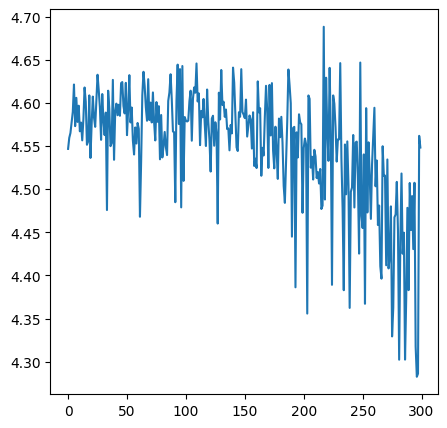

In [88]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.arange(300), train_loss_list)

### 4.5.3 テストデータで評価
ニューラルネットワークの学習では、訓練データ以外のデータを正しく認識できているかどうかを確認する必要がある。これは過学習が起きていないかの確認のために必要。そこで、1エポックごとに、訓練データとテストデータの認識精度を記録することにする。

In [92]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

# 学習過程でのlossを保存
train_loss_list = []
train_acc_list = []
test_acc_list = []

#ハイパーパラメータ
iters_num = 500
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

#1エポックあたりの繰り返し数
iter_per_epoch = 50

#モデルの定義
network = TwoLayerNet(input_size = 784, hidden_size = 10, output_size = 10)

#ミニバッチ学習
for i in tqdm(range(iters_num)):
  #ミニバッチ取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  #勾配計算
  grad = network.numerical_gradient(x_batch, t_batch)

  #パラメータ更新
  for key in network.params.keys():
    network.params[key] -= learning_rate * grad[key]

  #学習過程の記録
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test, acc | " + str(train_acc) +", " + str(test_acc))

  0%|          | 1/500 [00:02<19:58,  2.40s/it]

train acc, test, acc | 0.09751666666666667, 0.0974


 10%|█         | 51/500 [01:20<10:59,  1.47s/it]

train acc, test, acc | 0.09915, 0.1009


 20%|██        | 101/500 [02:36<10:02,  1.51s/it]

train acc, test, acc | 0.11236666666666667, 0.1135


 30%|███       | 151/500 [03:53<08:53,  1.53s/it]

train acc, test, acc | 0.11236666666666667, 0.1135


 40%|████      | 201/500 [05:09<07:43,  1.55s/it]

train acc, test, acc | 0.11366666666666667, 0.1143


 50%|█████     | 251/500 [06:25<06:30,  1.57s/it]

train acc, test, acc | 0.16161666666666666, 0.1636


 60%|██████    | 301/500 [07:43<05:31,  1.67s/it]

train acc, test, acc | 0.24751666666666666, 0.2491


 70%|███████   | 351/500 [08:58<04:26,  1.79s/it]

train acc, test, acc | 0.32826666666666665, 0.3347


 80%|████████  | 401/500 [10:15<03:00,  1.82s/it]

train acc, test, acc | 0.3289666666666667, 0.3262


 90%|█████████ | 451/500 [11:31<01:27,  1.78s/it]

train acc, test, acc | 0.5468, 0.5499


100%|██████████| 500/500 [12:46<00:00,  1.53s/it]


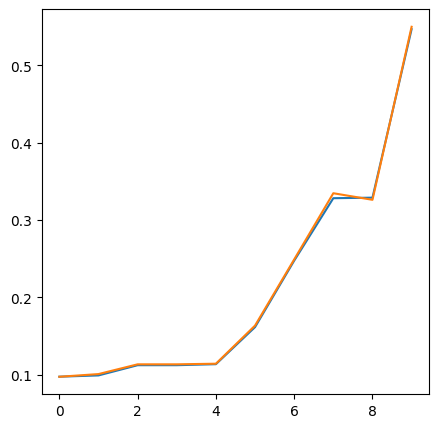

In [93]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.arange(len(train_acc_list)), train_acc_list)
ax.plot(np.arange(len(test_acc_list)), test_acc_list)
fig.show()